In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import json, yaml
from collections import defaultdict
import tqdm
import matplotlib.pyplot as plt

In [2]:
ROOT = Path().cwd()
LINEAGES = ROOT.joinpath("../lineages/").resolve()
EXAMPLE = ROOT.joinpath("example")
PHYLO = Path("../lineages").resolve()

In [13]:
from pathlib import Path
from argparse import ArgumentParser

roots = {#Pangolin
        "B": "B",
        "A": "A",
        "B.1": "B.1",
        "B.1.617.2": "B.1.617.2 (Delta)",
        "B.1.621": "B.1.621 (Mu)",
        "B.1.525": "B.1.525 (Eta)",
        "B.1.617.1": "B.1.617.1 (Kappa)",
        "B.1.177": "EU1",
        "B.1.526": "B.1.526 (Iota)",
        "B.1.427": "B.1.427 (Epsilon)",
        "B.1.351": "B.1.351 (Beta)",
        "B.1.2": "B.1.2",
        "B.1.1": "B.1.1",
        "B.1.1.529": "B.1.1.529 (Omicron)",
        "P.3": "P.3 (Theta)",
        "P.1": "P.1 (Gamma)",
        "B.1.1.7": "B.1.1.7 (Alpha)",
        "D.2": "D.2",
        "B.1.1.1": "B.1.1.1",
        "C.37": "C.37 (Lambda)",
        "BA.1": "BA.1 (Omicron)",
        "BA.2": "BA.2 (Omicron)",
        "BA.3": "BA.3 (Omicron)",
        "BA.4": "BA.4 (Omicron)",
        "BA.5": "BA.5 (Omicron)",
        "XBB": "XBB (Omicron)",
        "XBB.1.5": "XBB.1.5 (Omicron)",
        "XBB.1.16": "XBB.1.16 (Omicron)",
        "XBB.1.9.1": "XBB.1.9.1 (Omicron)",
        "XBB.2.3": "XBB.2.3 (Omicron)",
        "BA.2.75": "BA.2.75 (Omicron)",
        "BA.2.12.1": "BA.2.12.1 (Omicron)",
        "BQ.1": "BQ.1 (Omicron)",
        "XBB.2.3": "XBB.2.3 (Omicron)",
        "EG.5": "EG.5 (Omicron)",
        "BA.2.86": "BA.2.86 (Omicron)",
        "JN.1": "JN.1 (Omicron)",
        #V-TRACE 
        "B.1.1.523": "B.1.1.523 (Omicron)",
        "AT.1": "AT.1",
        "BA.2.10.1": "BA.2.10.1 (Omicron)",
        "BA.4/BA.5": "BA.4/BA.5 (Omicron)",
        "XBB.1.1": "XBB.1.1 (Omicron)",
        "XBB.1.5/XBB.1.9.1": "XBB.1.5/XBB.1.9.1 (Omicron)",
        "EG.5.1": "EG.5.1 (Omicron)",
        "BF.5" : "BF.5 (Omicron)",
        "BF.7" : "BF.7 (Omicron)",
        "CL.1" : "CL.1 (Omicron)",
    
   "LB.1" : "LB.1 (FLiRT)",
   "KU.2" : "KU.2 (FLiRT)",
    "KR.1" : "KR.1 (FLiRT)",
    "KS.1" : "KS.1 (FLiRT)",
    "KP.1.1" : "KP.1.1 (FLiRT)",
    "KP.2" : "KP.2 (FLiRT)",
    "KP.3" : "KP.3 (FLiRT)",
    "KP.4.1" : "KP.4.1 (FLiRT)",
    "KP.4.2" : "KP.4.2 (FLiRT)",
        "LA.2" : "LA.2 (FLiRT)",
        "LA.1" : "LA.1 (FLiRT)",
        "JN.1.16.1" : "JN.1.16.1 (FLiRT)",
        "KZ.1.1" : "KZ.1.1 (FLiRT)",
            "JN.1.7.4" : "JN.1.7.4 (FLiRT)",

        "Other": "Other"}


def open_md(strain):
    to_file = [i for i in PHYLO.glob(f"**/lineage_{strain}.md")]
    if len(to_file) == 0:
        #print(f'Линия {strain} неизвестна')
        return 0
    #if len(to_file) != 1:
    #    print(f"Найдено два файла для {strain}")
    with open(to_file[0], 'r') as f:
        md_content = f.read()    
    metadata_dict = {}
    # Проходим по каждой строке и добавляем ее в словарь
    for line in md_content.split('\n')[1:-2]:
        key, value = line.split(': ', 1)
        metadata_dict[key] = value
    return metadata_dict

def find_strain_root(strain):
    metadata_dict = open_md(strain)
    if metadata_dict == 0:
        return strain
    if type(metadata_dict) != dict:
        raise KeyError(f'Линия {strain} неизвестна')
    if "parent" in metadata_dict.keys() and strain not in roots.keys(): 
        res = metadata_dict["parent"]
        return find_strain_root(res)
    else:
        return strain
    
def final_linage_name(name):
    #name.replace("пред. ", "")
    name = name.split(" ")[0]
    res = find_strain_root(name)
    if res in roots:
        res = roots[res]
    else:
        res = roots['Other']
    return res

In [7]:
def create_roots_add(path_to_lineage):
    root_count = []
    for to_file in path_to_lineage.glob(f"**/lineage*.md"):
        metadata_dict = open_md(to_file.stem.split("lineage_")[1])
        if "parent" not in metadata_dict.keys() or len(metadata_dict["parent"]) == 0:
            root_count.append(to_file.stem.split("_")[1])
    roots_add = {i: i+" (Omicron)" for i in root_count}
    return roots_add

In [48]:
df = pd.read_csv(EXAMPLE / "ежедневный_расширенный_отчёт_2024-09-12 12-31-05.tsv.gz",sep='\t',quoting=3)
df

ParserError: Error tokenizing data. C error: Expected 69 fields in line 60948, saw 137


In [46]:
import csv
df = pd.read_csv(EXAMPLE / "ежедневный_расширенный_отчёт_2024-09-13 08-00-02.tsv.gz",sep="\t", quoting=csv.QUOTE_NONE)
df

/tmp/ipykernel_112284/58200110.py:2: DtypeWarning: Columns (18,22,23,28,29,30,40,43,44,45,46,53,62,67) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(EXAMPLE / "ежедневный_расширенный_отчёт_2024-09-13 08-00-02.tsv.gz",sep="\t", quoting=csv.QUOTE_NONE)


,#,id последовательности,Загрузил,Загрузил образец,Название образца,Тип образца,Область секвенирования,Место забора,Место забора. Страна,Место забора. Регион,...,Загрузил сиквенс,Панголин комментарий,Заключение,Заключение комментарий,Штрихкод,Дата отправки образца,Дата принятия образца,Дата предварительного результата,Дата секвенирования,Валидность
0,2,crie000002,crie_cnii,ФБУН ЦНИИ Эпидемиологии,7602093151,Первичный,Полный геном,Россия/Архангельская область/Архангельск,Россия,Архангельская область,...,ФБУН ЦНИИ Эпидемиологии,Assigned from designation hash.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Валидный
1,3,crie000003,crie_cnii,ФБУН ЦНИИ Эпидемиологии,7602087210,Первичный,Полный геном,Россия/Архангельская область/Архангельск,Россия,Архангельская область,...,ФБУН ЦНИИ Эпидемиологии,Assigned from designation hash.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Валидный
2,5,hnii000001,hniiem,ФБУН «Хабаровский НИИ»,22616,Первичный,Фрагмент генома (S-белок),Россия/Хабаровский край/Хабаровск,Россия,Хабаровский край,...,ФБУН «Хабаровский НИИ»,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Валидный
3,6,hnii000002,hniiem,ФБУН «Хабаровский НИИ»,22617,Первичный,Фрагмент генома (S-белок),Россия/Хабаровский край/Хабаровск,Россия,Хабаровский край,...,ФБУН «Хабаровский НИИ»,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Валидный
4,7,hnii000003,hniiem,ФБУН «Хабаровский НИИ»,22618,Первичный,Фрагмент генома (S-белок),Россия/Хабаровский край/Хабаровск,Россия,Хабаровский край,...,ФБУН «Хабаровский НИИ»,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Валидный
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329951,545227,prim001674,belik_prim,ФГБНУ НИИ имени Г.П.Сомова,RUSPrimorye_V-872,Первичный,Полный геном,"Россия, г Владивосток",Россия,Приморский край,...,ФГБНУ НИИ имени Г.П.Сомова,Usher placements: JN.1.13(1/3) JN.1.13.1(1/3) ...,NaN,NaN,NaN,NaN,NaN,NaN,2024-09-12 05:20:29,Валидный
329952,545228,prim001675,belik_prim,ФГБНУ НИИ имени Г.П.Сомова,RUSPrimorye_V-873,Первичный,Полный геном,"Россия, г Владивосток",Россия,Приморский край,...,ФГБНУ НИИ имени Г.П.Сомова,Usher placements: JN.1.13(1/4) JN.1.13.1(1/4) ...,NaN,NaN,NaN,NaN,NaN,NaN,2024-09-12 05:21:52,Валидный
329953,545229,prim001676,belik_prim,ФГБНУ НИИ имени Г.П.Сомова,RUSPrimorye_V-874,Первичный,Полный геном,"Россия, г Владивосток",Россия,Приморский край,...,ФГБНУ НИИ имени Г.П.Сомова,Usher placements: KP.3(1/1),NaN,NaN,NaN,NaN,NaN,NaN,2024-09-12 05:22:58,Валидный
329954,545230,prim001677,belik_prim,ФГБНУ НИИ имени Г.П.Сомова,RUSPrimorye_V-875,Первичный,Полный геном,"Россия, г Владивосток",Россия,Приморский край,...,ФГБНУ НИИ имени Г.П.Сомова,Usher placements: KP.3(1/1),NaN,NaN,NaN,NaN,NaN,NaN,2024-09-12 05:25:54,Валидный


In [12]:
%%time
df = pd.read_excel(EXAMPLE / "ежедневный_расширенный_отчёт_2024-09-12 12-31-05.xlsx")
df

CPU times: user 8min 27s, sys: 5.2 s, total: 8min 33s
Wall time: 8min 35s


,#,id последовательности,Загрузил,Загрузил образец,Название образца,Тип образца,Область секвенирования,Место забора,Место забора. Страна,Место забора. Регион,...,Unnamed: 127,Unnamed: 128,Unnamed: 129,Unnamed: 130,Unnamed: 131,Unnamed: 132,Unnamed: 133,Unnamed: 134,Unnamed: 135,Unnamed: 136
0,185563,dezi020741,pavlenko_sbm,ФБУН НИИ СБМ Роспотребнадзора (НИИ Дезинфектол...,2081,Культуральный,Полный геном,"Россия, Воронежская область",Россия,Воронежская область,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,185584,dezi020742,pavlenko_sbm,ФБУН НИИ СБМ Роспотребнадзора (НИИ Дезинфектол...,2087,Культуральный,Полный геном,"Россия, Воронежская область",Россия,Воронежская область,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,185597,dezi020746,pavlenko_sbm,ФБУН НИИ СБМ Роспотребнадзора (НИИ Дезинфектол...,2091,Культуральный,Полный геном,"Россия, Воронежская область",Россия,Воронежская область,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,185609,dezi020745,pavlenko_sbm,ФБУН НИИ СБМ Роспотребнадзора (НИИ Дезинфектол...,2094,Культуральный,Полный геном,"Россия, Воронежская область",Россия,Воронежская область,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,185613,dezi020743,pavlenko_sbm,ФБУН НИИ СБМ Роспотребнадзора (НИИ Дезинфектол...,2095,Культуральный,Полный геном,"Россия, Воронежская область",Россия,Воронежская область,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329919,431121,past029007,pastera,НИИ Пастера,K3300_g,Культуральный,Полный геном,Россия/Новгородская область,Россия,Новгородская область,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
329920,431143,vekt001212,korotkova_vector,ФБУН ФНИИВИ «Виром»,246,NaN,Фрагмент генома (S-белок),"Россия, г Екатеринбург",Россия,Свердловская область,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
329921,431144,vekt001213,korotkova_vector,ФБУН ФНИИВИ «Виром»,247,NaN,Фрагмент генома (S-белок),"Россия, г Екатеринбург",Россия,Свердловская область,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
329922,431145,vekt001214,korotkova_vector,ФБУН ФНИИВИ «Виром»,248,NaN,Фрагмент генома (S-белок),"Россия, г Екатеринбург",Россия,Свердловская область,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
df_2024 = df[df["Дата забора"] > "2024-01-01"]
df_2024.head()

,#,id последовательности,Загрузил,Загрузил образец,Название образца,Тип образца,Область секвенирования,Место забора,Место забора. Страна,Место забора. Регион,...,Unnamed: 127,Unnamed: 128,Unnamed: 129,Unnamed: 130,Unnamed: 131,Unnamed: 132,Unnamed: 133,Unnamed: 134,Unnamed: 135,Unnamed: 136
29266,481539,past031292,pastera,НИИ Пастера,74G-7491,NaN,Фрагмент генома (S-белок),"Россия, г Архангельск",Россия,Архангельская область,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29267,481540,past031291,pastera,НИИ Пастера,71G-7492,NaN,Фрагмент генома (S-белок),"Россия, г Архангельск",Россия,Архангельская область,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29268,481541,past031290,pastera,НИИ Пастера,71G-7493,NaN,Фрагмент генома (S-белок),"Россия, г Архангельск",Россия,Архангельская область,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29269,481542,past031289,pastera,НИИ Пастера,71G-7494,NaN,Фрагмент генома (S-белок),"Россия, г Архангельск",Россия,Архангельская область,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29270,481543,past031288,pastera,НИИ Пастера,71G7495,NaN,Фрагмент генома (S-белок),"Россия, г Архангельск",Россия,Архангельская область,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
df_2024.shape

(20303, 137)

In [18]:
df_2024 = df_2024[df_2024["Валидность"] == "Валидный"]

In [19]:
df_2024[["Генетический вариант(Скрипт VGARus)", "Pangolin"]] = df_2024[["Генетический вариант(Скрипт VGARus)", "Pangolin"]].astype(str) 

In [20]:
mask = df_2024["Pangolin"].isin(["nan"])
df_2024 = df_2024[~mask]

In [17]:
sars_c_2_df_tail = df.tail(50)

In [21]:
df_2024["Pangolin_collapse"] = df_2024["Pangolin"].apply(lambda x: final_linage_name(x))

In [22]:
df_2024[["Генетический вариант(Скрипт VGARus)", "Pangolin", "Pangolin_collapse"]]

,Генетический вариант(Скрипт VGARus),Pangolin,Pangolin_collapse
29329,nan,EG.5.1.1 Omicron (XBB.1-like),EG.5.1 (Omicron)
29331,nan,HK.3.1 Omicron (XBB.1-like),Other
29334,nan,FL.24 Omicron (XBB.1-like),XBB.1.9.1 (Omicron)
29339,nan,XBB.1.16.17 Omicron (XBB.1-like),XBB.1.16 (Omicron)
29340,nan,BA.2.86 Omicron (BA.2-like),BA.2.86 (Omicron)
...,...,...,...
60941,nan,JN.1.13 Omicron (BA.2-like),JN.1 (Omicron)
60942,nan,JN.1.13 Omicron (BA.2-like),JN.1 (Omicron)
60943,nan,JN.1.13 Omicron (BA.2-like),JN.1 (Omicron)
60944,nan,KP.3 Omicron (BA.2-like),KP.3 (FLiRT)


In [23]:
df_2024.shape

(10706, 138)

In [24]:
a = {   "LB.1" : "LB.1 (FLiRT)",
   "KU.2" : "KU.2 (FLiRT)",
    "KR.1" : "KR.1 (FLiRT)",
    "KS.1" : "KS.1 (FLiRT)",
    "KP.1.1" : "KP.1.1 (FLiRT)",
    "KP.2" : "KP.2 (FLiRT)",
    "KP.3" : "KP.3 (FLiRT)",
    "KP.4.1" : "KP.4.1 (FLiRT)",
    "KP.4.2" : "KP.4.2 (FLiRT)",
        "LA.2" : "LA.2 (FLiRT)",
        "LA.1" : "LA.1 (FLiRT)",
        "JN.1.16.1" : "JN.1.16.1 (FLiRT)",
        "KZ.1.1" : "KZ.1.1 (FLiRT)",
            "JN.1.7.4" : "JN.1.7.4 (FLiRT)"}

In [26]:
list(a.values())

['LB.1 (FLiRT)',
 'KU.2 (FLiRT)',
 'KR.1 (FLiRT)',
 'KS.1 (FLiRT)',
 'KP.1.1 (FLiRT)',
 'KP.2 (FLiRT)',
 'KP.3 (FLiRT)',
 'KP.4.1 (FLiRT)',
 'KP.4.2 (FLiRT)',
 'LA.2 (FLiRT)',
 'LA.1 (FLiRT)',
 'JN.1.16.1 (FLiRT)',
 'KZ.1.1 (FLiRT)',
 'JN.1.7.4 (FLiRT)']

In [27]:
mask = df_2024["Pangolin_collapse"].isin(list(a.values()))
mask.sum()

2132

In [30]:
df_2024_FLiRT = df_2024[mask]
df_2024_FLiRT

,#,id последовательности,Загрузил,Загрузил образец,Название образца,Тип образца,Область секвенирования,Место забора,Место забора. Страна,Место забора. Регион,...,Unnamed: 128,Unnamed: 129,Unnamed: 130,Unnamed: 131,Unnamed: 132,Unnamed: 133,Unnamed: 134,Unnamed: 135,Unnamed: 136,Pangolin_collapse
41636,501455,vect017354,sivay_vector,ФБУН ГНЦ ВБ «Вектор»,27R,NaN,Полный геном,"Россия, г Хабаровск",Россия,Хабаровский край,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,JN.1.16.1 (FLiRT)
44343,508708,vect018302,sivay_vector,ФБУН ГНЦ ВБ «Вектор»,2,NaN,Полный геном,"Россия, г Барнаул",Россия,Алтайский край,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,JN.1.16.1 (FLiRT)
45397,510100,vect018354,sivay_vector,ФБУН ГНЦ ВБ «Вектор»,1369,NaN,Полный геном,"Россия, Новосибирская обл",Россия,Новосибирская область,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,JN.1.16.1 (FLiRT)
45590,510372,vect018610,sivay_vector,ФБУН ГНЦ ВБ «Вектор»,75,NaN,Полный геном,"Россия, г Владивосток",Россия,Приморский край,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,JN.1.16.1 (FLiRT)
45712,510549,vect018639,sivay_vector,ФБУН ГНЦ ВБ «Вектор»,2,NaN,Полный геном,"Россия, г Барнаул",Россия,Алтайский край,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,JN.1.16.1 (FLiRT)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60938,545220,prim001670,belik_prim,ФГБНУ НИИ имени Г.П.Сомова,RUSPrimorye_V-868,Первичный,Полный геном,"Россия, г Владивосток",Россия,Приморский край,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,KP.1.1 (FLiRT)
60939,545222,prim001671,belik_prim,ФГБНУ НИИ имени Г.П.Сомова,RUSPrimorye_V-869,Первичный,Полный геном,"Россия, г Владивосток",Россия,Приморский край,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,KP.1.1 (FLiRT)
60940,545225,prim001672,belik_prim,ФГБНУ НИИ имени Г.П.Сомова,RUSPrimorye_V-870,Первичный,Полный геном,"Россия, г Владивосток",Россия,Приморский край,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,KP.1.1 (FLiRT)
60944,545229,prim001676,belik_prim,ФГБНУ НИИ имени Г.П.Сомова,RUSPrimorye_V-874,Первичный,Полный геном,"Россия, г Владивосток",Россия,Приморский край,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,KP.3 (FLiRT)


In [34]:
df_2024_FLiRT[["Генетический вариант(Скрипт VGARus)", "Pangolin", "Pangolin_collapse"]]

,Генетический вариант(Скрипт VGARus),Pangolin,Pangolin_collapse
41636,nan,JN.1.16.1 Omicron (BA.2-like),JN.1.16.1 (FLiRT)
44343,nan,JN.1.16.1 Omicron (BA.2-like),JN.1.16.1 (FLiRT)
45397,nan,JN.1.16.1 Omicron (BA.2-like),JN.1.16.1 (FLiRT)
45590,nan,JN.1.16.1 Omicron (BA.2-like),JN.1.16.1 (FLiRT)
45712,nan,JN.1.16.1 Omicron (BA.2-like),JN.1.16.1 (FLiRT)
...,...,...,...
60938,nan,KP.1.1 Omicron (BA.2-like),KP.1.1 (FLiRT)
60939,nan,KP.1.1 Omicron (BA.2-like),KP.1.1 (FLiRT)
60940,nan,KP.1.1 Omicron (BA.2-like),KP.1.1 (FLiRT)
60944,nan,KP.3 Omicron (BA.2-like),KP.3 (FLiRT)


In [39]:
df_2024_FLiRT_agg = df_2024_FLiRT.groupby(by="Pangolin_collapse").aggregate({"Pangolin_collapse":"count"})
df_2024_FLiRT_agg = df_2024_FLiRT_agg.rename(columns={"Pangolin_collapse":"count"})
df_2024_FLiRT_agg

,count
Pangolin_collapse,
JN.1.16.1 (FLiRT),709
KP.1.1 (FLiRT),80
KP.2 (FLiRT),181
KP.3 (FLiRT),75
KP.4.1 (FLiRT),1
KP.4.2 (FLiRT),4
KS.1 (FLiRT),909
LA.1 (FLiRT),12
LA.2 (FLiRT),1


In [43]:
df_2024_FLiRT_agg.sort_values(by="count", ascending=False).to_excel("VGARus_FLiRT_2024.xlsx")

<Axes: >

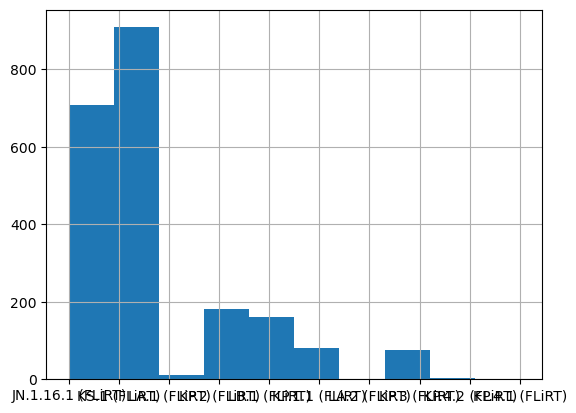

In [31]:
df_2024_FLiRT["Pangolin_collapse"].hist()

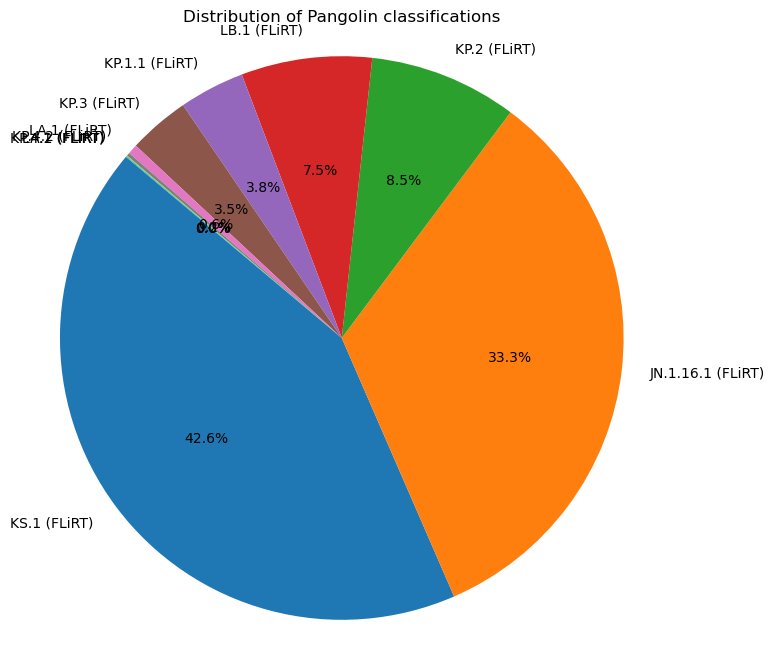

In [32]:
counts = df_2024_FLiRT["Pangolin_collapse"].value_counts()

# Создание круговой диаграммы
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Distribution of Pangolin classifications')

# Отображение диаграммы
plt.show()

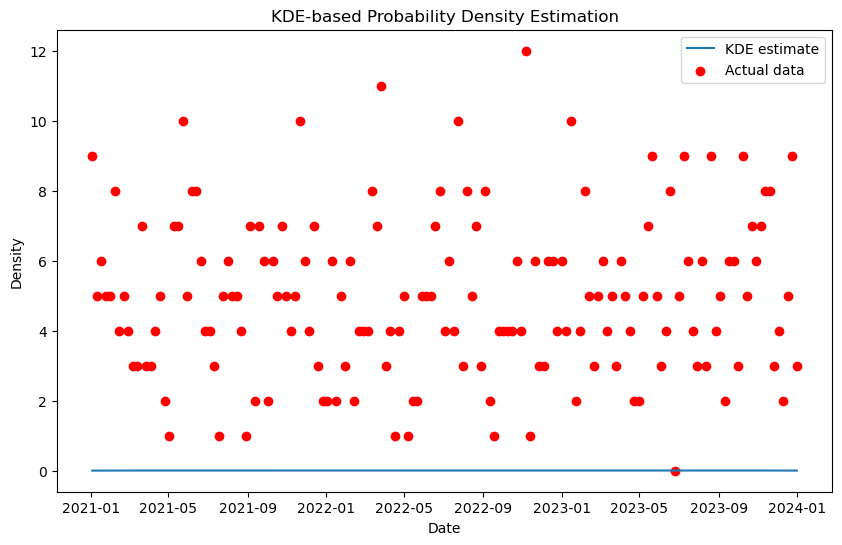

Probability of the new sequence count fitting the existing pattern: 0.0029306100124831653


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

# Генерация искусственных данных
np.random.seed(0)
dates = pd.date_range(start="2021-01-01", end="2024-01-01", freq="W")
n_weeks = len(dates)
sequence_counts = np.random.poisson(lam=5, size=n_weeks)  # Количество последовательностей за неделю

# Создание DataFrame
df = pd.DataFrame({
    'date': dates,
    'sequence_count': sequence_counts
})

# Фильтрация по конкретному варианту (например, BA.2)
df['variant'] = 'BA.2'
# Здесь можно заменить фильтрацию на реальных данных
# df = df[df['variant'] == 'BA.2']

# Построение ядровой оценки плотности (KDE) для моделирования вероятности
weeks = np.array(range(n_weeks)).reshape(-1, 1)
kde = KernelDensity(kernel='gaussian', bandwidth=5).fit(weeks, df['sequence_count'])
log_density = kde.score_samples(weeks)

# Визуализация результатов
plt.figure(figsize=(10, 6))
plt.plot(df['date'], np.exp(log_density), label='KDE estimate')
plt.scatter(df['date'], df['sequence_count'], color='red', label='Actual data')
plt.title('KDE-based Probability Density Estimation')
plt.xlabel('Date')
plt.ylabel('Density')
plt.legend()
plt.show()

# Оценка вероятности новой последовательности
new_date_index = len(dates)  # например, новая неделя
new_count = 20  # количество новых последовательностей

# Вычисление плотности для новой даты
log_prob = kde.score_samples(np.array([[new_date_index]]))[0]
prob = np.exp(log_prob)

print(f"Probability of the new sequence count fitting the existing pattern: {prob}")


In [4]:
kde

KernelDensity(bandwidth=5)